# Exploratory data analysis for skeleton joint forecasting

## Let's bring up how many files do we have

In [1]:
import os
from skelcast.data.prepare_data import get_missing_files, get_skeleton_files, filter_missing, should_blacklist

DATA_DIR = os.environ['NTU_RGBD_DATA_DIR']
MISSING_FILES_DIR = '../data/missing'

if not DATA_DIR:
    raise ValueError("NTU_RGBD_DATA_DIR environment variable is not set or empty.")

missing_skel_files = get_missing_files(MISSING_FILES_DIR)
print(f'Missing skeleton files: {len(missing_skel_files)}')
skeleton_files = get_skeleton_files(DATA_DIR)

print(f"Found {len(skeleton_files)} .skeleton files.")

skeleton_files_filtered = filter_missing(skeleton_files=skeleton_files,
                                         missing_skeleton_names=missing_skel_files)

skeleton_files_clean = []
for fname in skeleton_files_filtered:
    if should_blacklist(fname):
        continue
    else:
        skeleton_files_clean.append(fname)

print(f'Skeleton Files size after removing blacklisted files: {len(skeleton_files_clean)}')

nturgb_d.txt
nturgb_d_120.txt
Missing skeleton files: 837
Found 114480 .skeleton files.
Skeleton files after filtering: 114478 files left.
Skeleton Files size after removing blacklisted files: 114122


In [2]:
from skelcast.data.dataset import read_skeleton_file

durations = []
nbodies = []
for fname in skeleton_files_clean:
    mat = read_skeleton_file(fname, save_rgbxy=False, save_depthxy=False, save_skelxyz=True)
    # print(len(mat['nbodys']))
    # print(mat['skel_body0'].shape)
    nbodies.append(mat['nbodys'])
    durations.append(len(mat['nbodys']))

## Let's see what's happening

We first calculate some initial statistics about a small sample of our dataset. We calculate the min, max durations of our activities, and then compute the average and median duration of them.

Then, we move on in padding the entire list, so that all activities have the "same" duration, by adding `-1` values, indicating that there's no person involved in the activity, since the activity finished. We take a small sample from the padded array and plot the number of people involved in an activity w.r.t time. We can see that in some cases, there's a lot happening go on in and out of the scene (see between 483 and 504 in the y-axis of the plot).

Maximum duration of an activity: 300
Minimum duration of an activity: 1
Mean duration of activities: 71.41054310299504
Median of durations of activities: 66.0


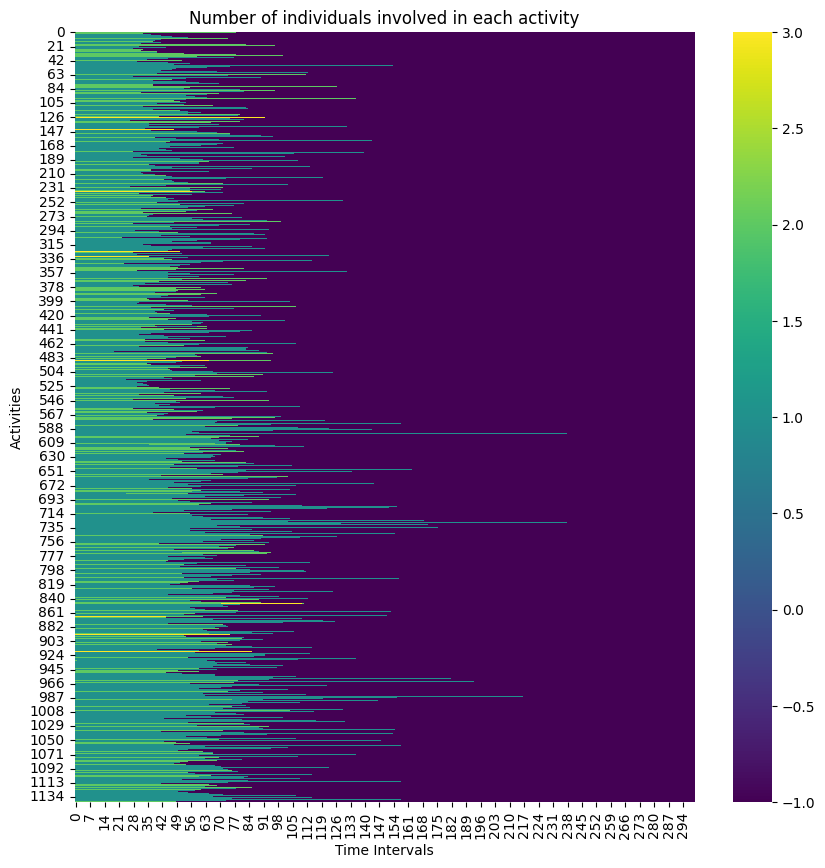

In [3]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

print(f'Maximum duration of an activity: {max(durations)}')
print(f'Minimum duration of an activity: {min(durations)}')
print(f'Mean duration of activities: {np.mean(durations)}')
print(f'Median of durations of activities: {np.median(durations)}')

homogeneous_list = []
for nbody in nbodies:
    diff = max(durations) - len(nbody)
    homogeneous_list.append(nbody + [-1] * diff)

array_of_durations = np.array(homogeneous_list)
# Let's assume 'data' is your numpy array
# You might want to sample or aggregate your data before plotting
# For instance, this is how you could take one out of every 100 activities:
reduced_data = array_of_durations[::100]

# Now, plotting the heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(reduced_data, cmap='viridis')
plt.title('Number of individuals involved in each activity')
plt.xlabel('Time Intervals')
plt.ylabel('Activities')
plt.show()

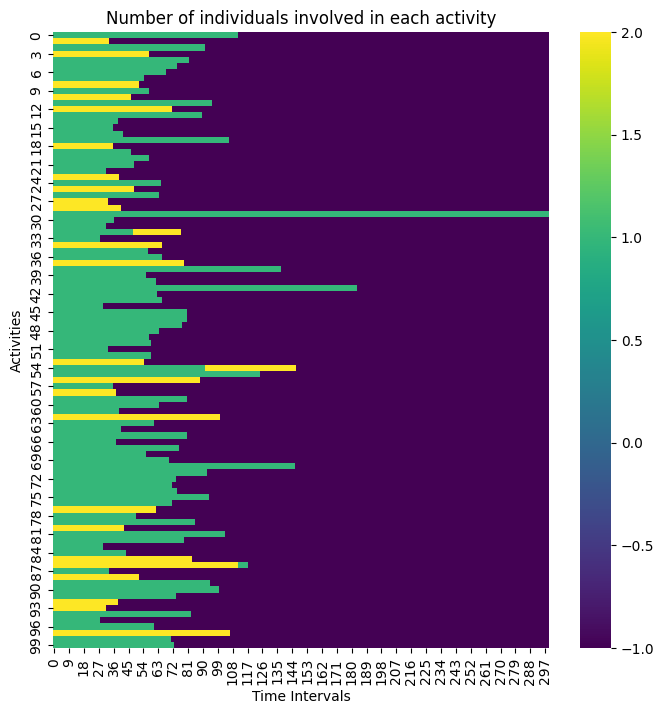

In [48]:
random_indices = np.random.randint(0, array_of_durations.shape[0], 100)

# Now, plotting the heatmap
plt.figure(figsize=(8, 8))
sns.heatmap(array_of_durations[random_indices, :], cmap='viridis')
plt.title('Number of individuals involved in each activity')
plt.xlabel('Time Intervals')
plt.ylabel('Activities')
plt.show()

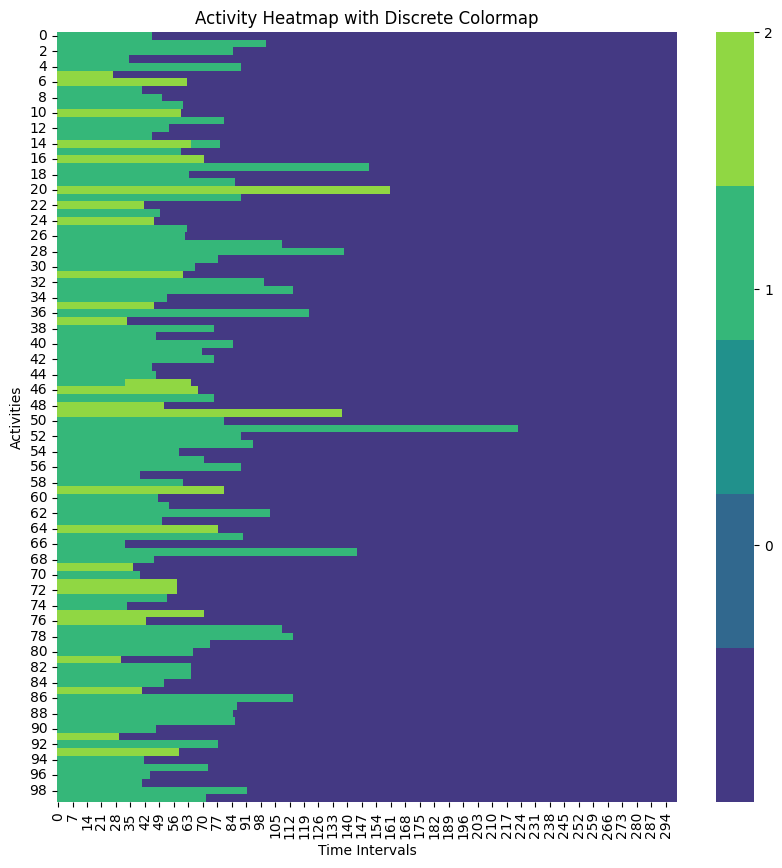

In [57]:
from matplotlib.colors import ListedColormap

random_indices = np.random.randint(0, array_of_durations.shape[0], 100)
# Assuming 'data' is your numpy array and is already loaded
# Optionally reduce the dataset size if necessary
reduced_data = array_of_durations[random_indices, :]

# Define the maximum number of people to set the bins for the colormap
max_people = int(np.max(array_of_durations))
color_bins = max_people + 1  # plus two to include zero

# Create a discrete colormap
cmap = sns.color_palette("viridis", color_bins)

# Plot the heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(reduced_data, cmap=ListedColormap(cmap), cbar_kws={'ticks': range(color_bins)})
plt.title('Activity Heatmap with Discrete Colormap')
plt.xlabel('Time Intervals')
plt.ylabel('Activities')
plt.show()

We create a histogram to inspect the distribution of people involved in each activity. As we see, all activities are mostly conducted by 1 person. This clearly indicates that we have to deal with this class imbalance.

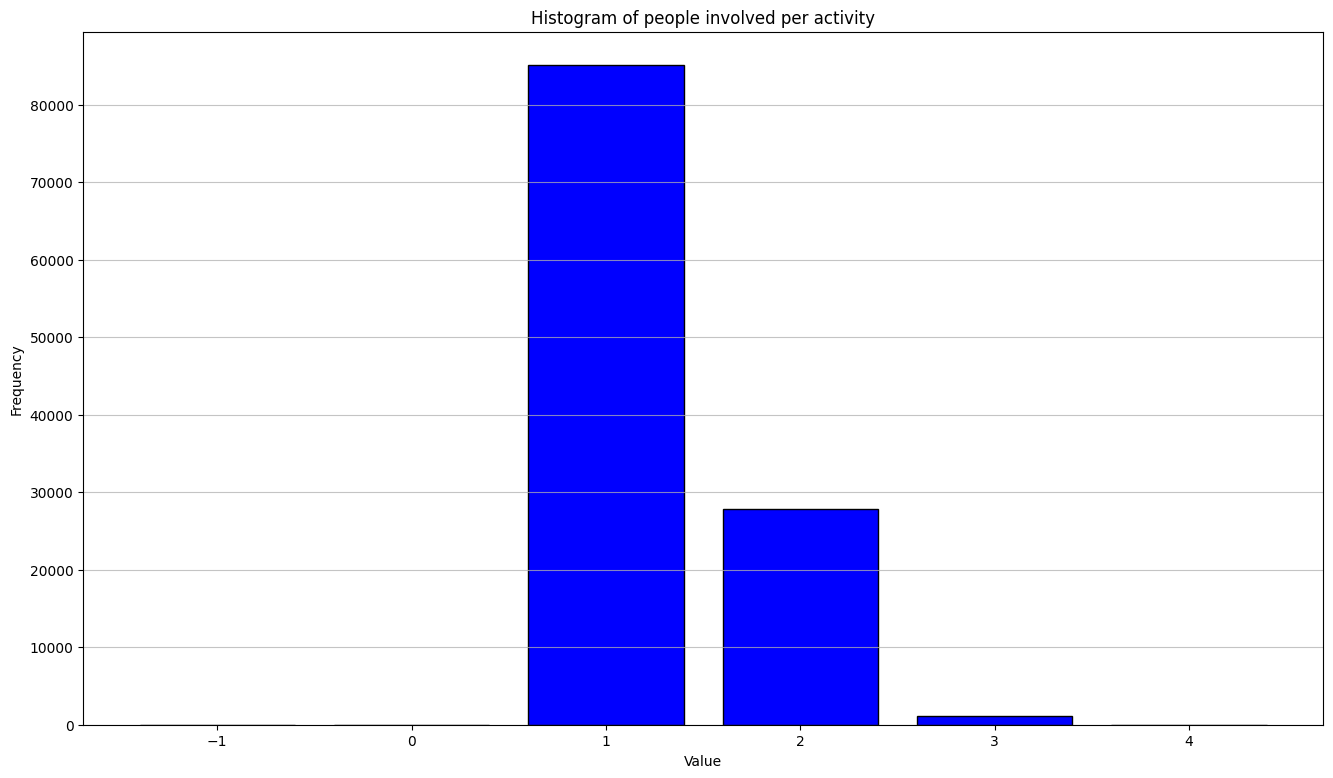

In [77]:
array_max_people = np.max(array_of_durations, axis=1)
bins = np.arange(array_of_durations.min(), array_of_durations.max() + 2) - 0.5
plt.figure(figsize=(16, 9))
counts, edges, patches = plt.hist(array_max_people, bins=bins, rwidth=0.8, color='blue', edgecolor='black')
plt.title('Histogram of people involved per activity')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

We plot the histogram that indicates the distribution of duration per activity. We see that it is positively skewed.

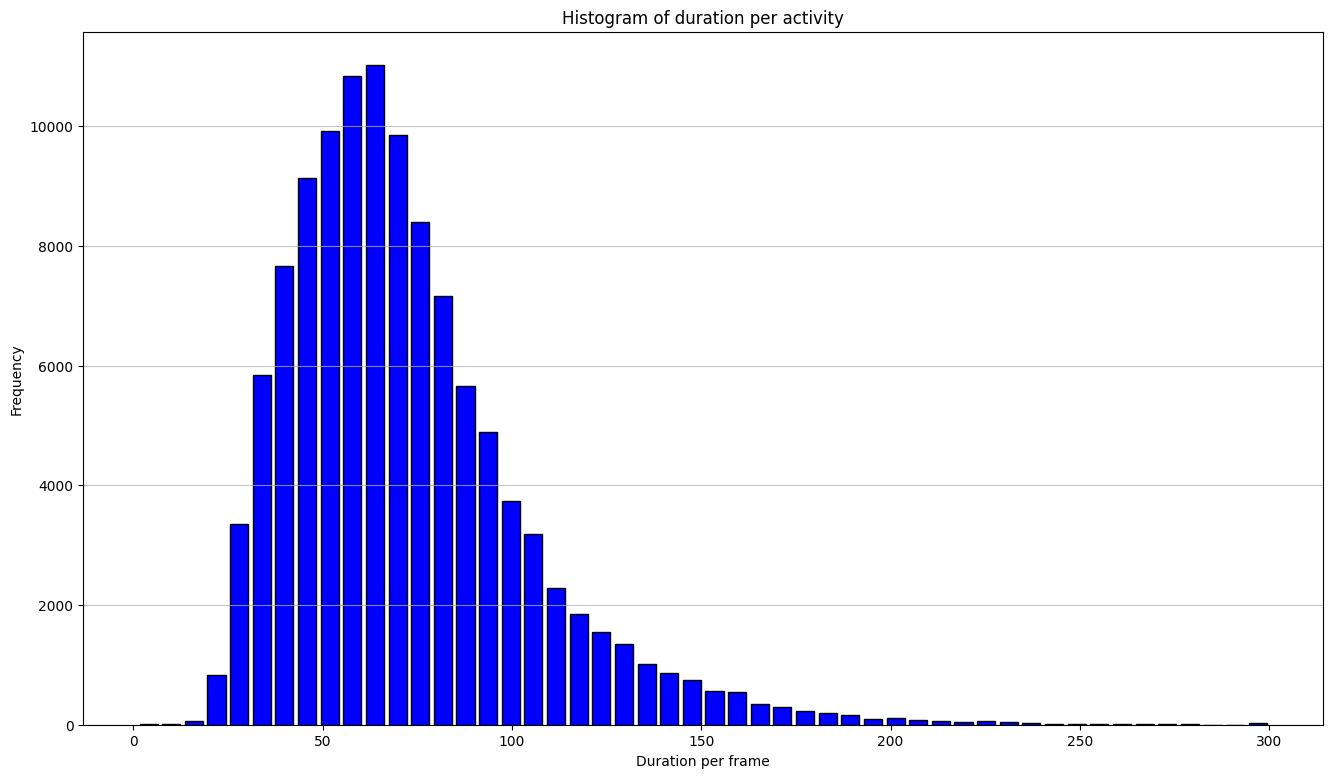

In [81]:
bins = np.arange(min(durations), max(durations) + 2) - 0.5
plt.figure(figsize=(16, 9))
counts, edges, patches = plt.hist(durations, bins=50, rwidth=0.8, color='blue', edgecolor='black')
plt.title('Histogram of duration per activity')
plt.xlabel('Duration per frame')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [2]:
from skelcast.data.dataset import NTURGBDDataset

dataset = NTURGBDDataset(data_directory=DATA_DIR, missing_files_dir=MISSING_FILES_DIR)
mat = dataset[290]

nturgb_d.txt
nturgb_d_120.txt
Skeleton files after filtering: 114478 files left.


In [9]:
bodies = []
for i in range(4):
    if mat.get(f'skel_body{i}') is not None:
        bodies.append(mat.get(f'skel_body{i}'))
    else:
        bodies.append(None)

In [1]:
import os

import torch
import torch.nn as nn

from skelcast.data.dataset import NTURGBDDataset

DATA_DIR = os.environ['NTU_RGBD_DATA_DIR']
MISSING_FILES_DIR = '../data/missing'

if not DATA_DIR:
    raise ValueError("NTU_RGBD_DATA_DIR environment variable is not set or empty.")

dataset = NTURGBDDataset(DATA_DIR, MISSING_FILES_DIR, max_context_window=40)

nturgb_d.txt
nturgb_d_120.txt
Skeleton files after filtering: 114478 files left.


In [2]:
import matplotlib.pyplot as plt
sample = dataset[66]
# x = sample.x.numpy()
# y = sample.y.numpy()

from torch.utils.data import DataLoader

from skelcast.data.dataset import nturbgd_collate_fn

data_loader = DataLoader(dataset=dataset, batch_size=1, shuffle=True, collate_fn=nturbgd_collate_fn)

for batch in data_loader:
    batch_size, n_samples, seq_len, dims = batch.x.shape 
    print(f'Input windows shape: {batch.x.shape}')
    print(f'Target windows shape: {batch.y.shape}')
    print(f'Batch sequence lengths: {batch.seq_len}')
    print(f'Viewed as an unified batch: {batch.x.view(batch_size * n_samples, seq_len, dims).shape}')
    break

Input windows shape: torch.Size([1, 260, 40, 300])
Target windows shape: torch.Size([1, 260, 40, 300])
Batch sequence lengths: tensor([69])
Viewed as an unified batch: torch.Size([260, 40, 300])


In [3]:
import torch.nn.functional as F

class SimpleLSTMRegressor(nn.Module):
    def __init__(self, input_size=300, n_hidden=64, n_layers=2) -> None:
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=n_hidden, num_layers=n_layers, batch_first=True)
        self.linear = nn.Linear(in_features=n_hidden, out_features=input_size, bias=True)

    def forward(self, x):
        _, (hidden, _) = self.lstm(x)
        out = self.linear(hidden[-1])
        return out
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

class CNNLSTM(nn.Module):
    def __init__(self):
        super(CNNLSTM, self).__init__()
        # Define CNN layers
        self.conv1 = nn.Conv3d(in_channels=4, out_channels=16, kernel_size=(3, 3, 3), stride=1, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool3d(kernel_size=(2, 2, 2))
        # Define LSTM layers
        self.lstm = nn.LSTM(input_size=16*12*12*3, hidden_size=128, num_layers=2, batch_first=True)
        # Define output layer
        self.fc = nn.Linear(128, 25*3)  # Predicting 25 joints with 3 coordinates each

    def forward(self, x):
        # CNN layers
        x = self.pool(self.relu(self.conv1(x)))
        x = x.view(x.size(0), -1)  # Flatten the output for LSTM
        # LSTM layers
        x, _ = self.lstm(x)
        # Fully connected layer
        x = self.fc(x[:, -1, :])  # We only use the last LSTM output
        return x

cuda


In [32]:
model = CNNLSTM()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

loss_history = []
n_epochs = 300

criterion = criterion.to(device=device)
model = model.to(device=device)
# print(batch.x.shape)
x = batch.x.view(batch_size, n_samples, seq_len, dims).to(device)
y = batch.y.view(batch_size, n_samples, seq_len, dims).to(device)
for epoch in range(n_epochs):
    print(f'Epoch: {epoch + 1}')
    optimizer.zero_grad()
    predictions = model(x)
    loss = criterion(predictions, y)
    print(f'Loss: {loss.item()}')
    loss_history.append(loss.item())
    loss.backward()
    optimizer.step()


Epoch: 1


RuntimeError: Given groups=1, weight of size [16, 4, 3, 3, 3], expected input[1, 1, 280, 20, 300] to have 4 channels, but got 1 channels instead

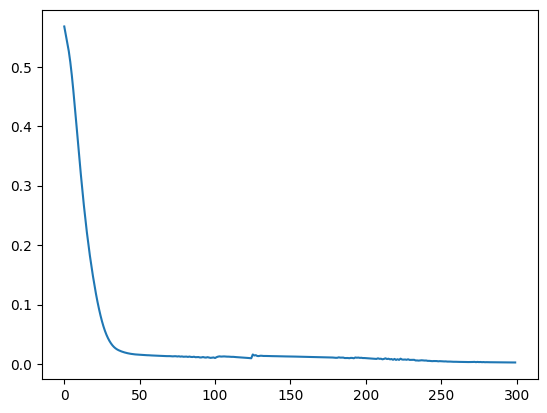

In [12]:
import numpy as np
plt.plot(loss_history)
plt.show()

Sample1  shape: (280, 20, 4, 25, 3)
torch.Size([10, 4, 25, 3])
Type of historical data: <class 'torch.Tensor'>
Shape of historical data: torch.Size([10, 4, 25, 3])


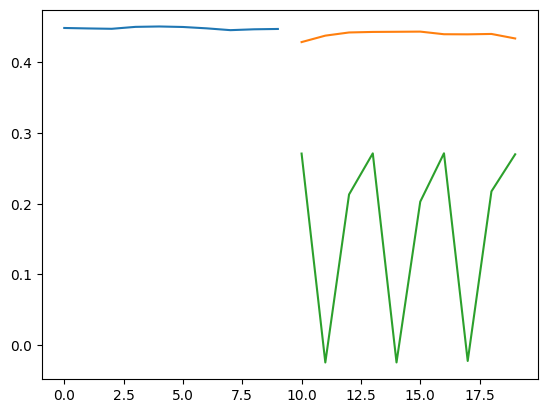

In [25]:
# Draw a sample
sample = batch.x
sample = sample.view(batch_size, n_samples, 20, 4,  25, 3)
sample = sample.detach().cpu().numpy()
sample_1 = sample[0, :, ...]
print(f'Sample1  shape: {sample_1.shape}')
import numpy as np
# pred = model(batch.x.view(batch_size * n_samples, seq_len, dims).to(device))
# print(pred.shape)

# pred_1 = pred.view(batch_size, n_samples, 20, 4, 25, 3)
# pred_1 = pred_1.detach().cpu().numpy()
# pred_1 = pred_1[0, :, ...]
# print(f'Prediction shape: {pred_1.shape}')

historical_data = torch.tensor(sample_1[55, :10, :, :, :])
# historical_data = historical_data.view(10, 300).to(device=device)
print(historical_data.shape)
def forecast(x, samples_to_forecast=10):
    forecasted_values = []
    with torch.no_grad():
        for _ in range(samples_to_forecast):
            historical_data_tensor = torch.as_tensor(x).view(10, 300).to(device=device)
            predicted_value = model(historical_data_tensor).view(10, 4, 25, 3).cpu().numpy()[0, :]
            # print(f'Predicted value shape: {predicted_value.shape}')
            forecasted_values.append(predicted_value)
            x = np.roll(x, shift=-1)
            x[-1] = predicted_value
    return forecasted_values

print(f'Type of historical data: {type(historical_data)}')
print(f'Shape of historical data: {historical_data.shape}')
result = forecast(historical_data, 10)
results = np.array([r[0, 0, 0] for r in result])

# Plot the sample
x = np.arange(0, 20)
plt.plot(x[:10], sample_1[0, :10, 0, 0, 0])
plt.plot(x[10:], sample_1[0, 10:, 0, 0, 0])
plt.plot(x[10:], results)
plt.show()


In [115]:
for r in result:

    print(r[0, 0, 0])

0.13437356
0.13437356
0.13437356
0.13437356
0.13437356
0.13437356
0.13437356
0.13437356
0.13437356
0.13437356


In [4]:
from sklearn.preprocessing import MinMaxScaler

sample = dataset[0]
sample_x = sample.x
sample_y = sample.y
print(f'Sample x shape: {sample_x.shape}')
print(f'Sample y shape: {sample_y.shape}')
sample_x_comprehensive = sample_x.view(260, 40, 4, 25, 3)
sample_y_comprehensive = sample_y.view(260, 40, 4, 25, 3)
print(f'sample_x_comprehensive.shape: {sample_x_comprehensive.shape}')
print(f'sample_y_comprehensive.shape: {sample_y_comprehensive.shape}')
# Take only the first joint from the first person only for the x axis
input_window = sample_x_comprehensive[:, :, 0, 0, 0]
target_window = sample_y_comprehensive[:, :, 0, 0, 0]

scaler = MinMaxScaler(feature_range=(0,1))
input_window = scaler.fit_transform(input_window)
target_window = scaler.fit_transform(target_window)

input_window = torch.as_tensor(input_window).unsqueeze(-1).float()
target_window = torch.as_tensor(target_window).unsqueeze(-1).float()
print(f'input_window.shape: {input_window.shape}')
print(f'target_window.shape: {target_window.shape}')

model = SimpleLSTMRegressor(input_size=1, n_hidden=64, n_layers=2)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss(reduction='mean')

loss_history = []
n_epochs = 200

criterion = criterion.to(device=device)
model = model.to(device=device)


input_window = input_window.to(device)


target_window = target_window.to(device)

for epoch in range(n_epochs):
    print(f'Epoch: {epoch + 1}')
    optimizer.zero_grad()
    pred = model(input_window)
    loss = criterion(pred, target_window)
    # print(f'Pred: {pred[0, 0]} Actual: {target_window[0, 0]}')
    print(f'Loss: {loss.item()}')
    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())


Sample x shape: torch.Size([260, 40, 300])
Sample y shape: torch.Size([260, 40, 300])
sample_x_comprehensive.shape: torch.Size([260, 40, 4, 25, 3])
sample_y_comprehensive.shape: torch.Size([260, 40, 4, 25, 3])
input_window.shape: torch.Size([260, 40, 1])
target_window.shape: torch.Size([260, 40, 1])
Epoch: 1


/home/kaseris/Documents/scraping/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([260, 40, 1])) that is different to the input size (torch.Size([260, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (260) must match the size of tensor b (40) at non-singleton dimension 1

sequence_to_plot.shape: (10, 1)
ground_truth.shape: (20, 1)


ValueError: x and y must have same first dimension, but have shapes (10,) and (20, 1)

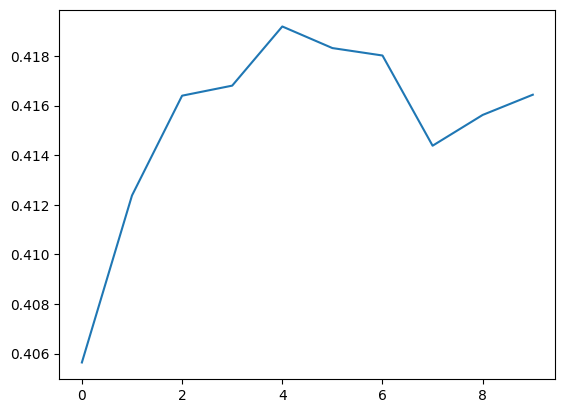

In [201]:
num_forecast_steps = 10
 
sequence_to_plot = input_window[0, :10].cpu().numpy()
print(f'sequence_to_plot.shape: {sequence_to_plot.shape}')
ground_truth = input_window[0, 10:30].cpu().numpy()
print(f'ground_truth.shape: {ground_truth.shape}')
x = np.arange(0, 20)

forecasted_values = []
historical_data = sequence_to_plot

with torch.no_grad():
    for _ in range(num_forecast_steps*2):
        historical_data_tensor = torch.as_tensor(historical_data).unsqueeze(0).to(device=device)
        # print(f'historical_data_tensor.shape: {historical_data_tensor.shape}')
        predicted_value = model(historical_data_tensor).cpu().numpy()[0, 0]
        # print(f'predicted_value.shape: {predicted_value.shape}')
        forecasted_values.append(predicted_value[0])
        historical_data = np.roll(historical_data, shift=-1)
        historical_data[-1] = predicted_value

plt.plot(x[:10], sequence_to_plot)
plt.plot(x[10:], ground_truth)
plt.plot(x, forecasted_values)
plt.show()

In [186]:
sequence_to_plot = input_window[0, :5].cpu().numpy()
print(f'sequence_to_plot.shape: {sequence_to_plot.shape}')
ground_truth = input_window[0, 5:10].cpu().numpy()
print(f'ground_truth.shape: {ground_truth.shape}')
x = np.arange(0, 10)

forecasted_values = []
historical_data = sequence_to_plot

historical_data_tensor = torch.as_tensor(historical_data).unsqueeze(0).to('cuda')
pred = model(historical_data_tensor)

sequence_to_plot.shape: (5, 1)
ground_truth.shape: (5, 1)


In [187]:
pred

tensor([[[0.3819],
         [0.4344],
         [0.4412],
         [0.4542],
         [0.4362]]], device='cuda:0', grad_fn=<ViewBackward0>)

In [190]:
input_window[0, 1:6]

tensor([[0.4124],
        [0.4164],
        [0.4168],
        [0.4192],
        [0.4183]], device='cuda:0')